In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, RandomAffine, Compose
import matplotlib.pyplot as plt
from random import randint

In [2]:
# Download training data from open datasets.
og_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

T = RandomAffine(degrees=90, translate=(0.2,0.2), scale=(0.4, 1.2))

random_training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        RandomAffine(degrees=25, translate=(0.3,0.3), scale=(0.8, 1.2))
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

training_data = ConcatDataset([og_training_data, random_training])

# Download test data from open datasets.
og_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

random_testing = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        RandomAffine(degrees=25, translate=(0.3,0.3), scale=(0.8, 1.2))
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

test_data = ConcatDataset([og_test_data, random_testing])


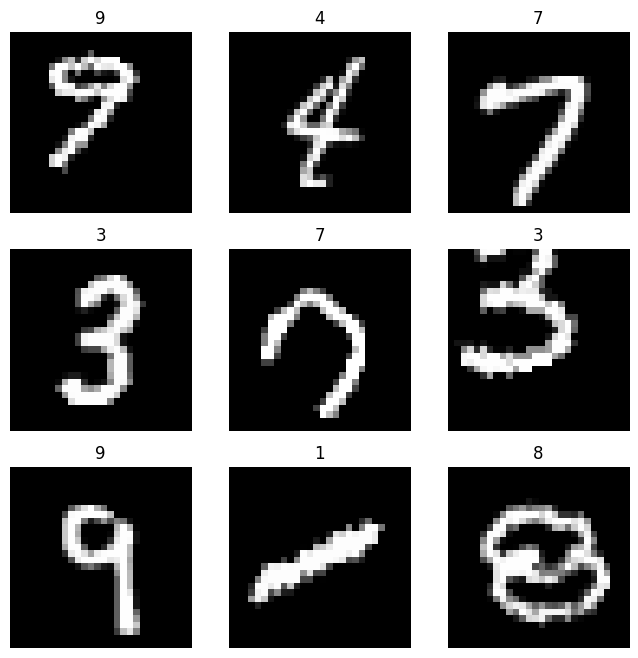

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = randint(0,len(training_data))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label.argmax(0).item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.Sigmoid(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()


    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
loss_fn = nn.MSELoss()
learning_rate = 5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1+50}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 51
-------------------------------
loss: 0.093018  [    0/120000]
loss: 0.093164  [25600/120000]
loss: 0.091602  [51200/120000]
loss: 0.094043  [76800/120000]
loss: 0.091699  [102400/120000]
Test Error: 
 Accuracy: 9.8%, Avg loss: 0.091214 

Epoch 52
-------------------------------
loss: 0.090332  [    0/120000]
loss: 0.090820  [25600/120000]
loss: 0.093262  [51200/120000]
loss: 0.091064  [76800/120000]
loss: 0.090332  [102400/120000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 0.091420 

Epoch 53
-------------------------------
loss: 0.091162  [    0/120000]
loss: 0.089941  [25600/120000]
loss: 0.092480  [51200/120000]
loss: 0.090723  [76800/120000]
loss: 0.091504  [102400/120000]
Test Error: 
 Accuracy: 10.1%, Avg loss: 0.090558 

Epoch 54
-------------------------------
loss: 0.088867  [    0/120000]
loss: 0.089551  [25600/120000]
loss: 0.094385  [51200/120000]
loss: 0.091406  [76800/120000]
loss: 0.090283  [102400/120000]
Test Error: 
 Accuracy: 9.8%, Avg loss: 0.091158 

Epoch 

In [23]:
modelName = f"modelSigmoid_eta_{'{:e}'.format(learning_rate).replace('.','_')}.pth"

In [24]:
torch.save(model.state_dict(), modelName)
print(f"Saved PyTorch Model State to {modelName}")

Saved PyTorch Model State to modelSigmoid_eta_5_000000e+00.pth


In [25]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(modelName))

<All keys matched successfully>

Test Error: 
 Accuracy: 9.8%, Avg loss: 0.090704 



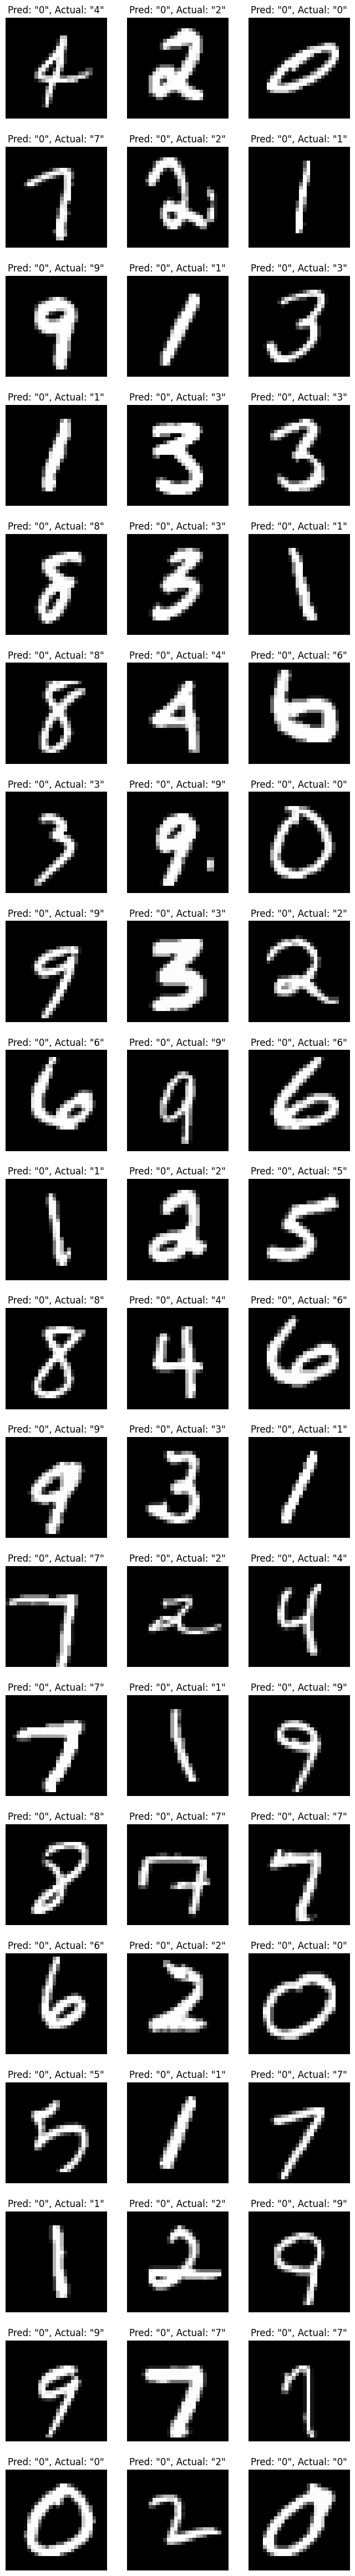

In [26]:
model.eval()
test_loop(test_dataloader, model, loss_fn)
cols, rows = 3, 20
figure = plt.figure(figsize=(cols*2+2, rows*3))
for i in range(1, cols * rows + 1):
    sample_idx = randint(0,len(og_test_data))
    img, label = og_test_data[sample_idx]
    with torch.no_grad():
        pred = model(img.to(device))
        predicted, actual = pred.argmax(1).item(), label.argmax(0)
    figure.add_subplot(rows, cols, i)
    plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()